# Artificial Intelligence - Fall 2024 - Laboratory 03 : State-Space Search

## Introduction

State-space search or pathfinding requires a sequence of actions in the space of states \begin{equation*} s_{0} \mapsto s_{f} \end{equation*} which can be:
* explored, 
* discovered(frontier), 
* unexplored.

**A\*** is the most widespread option for this type of problems in AI: the algorithm finds the shortest path and uses a heuristic to guide itself.

## Today's Challenge

Given a bidimensional map with various obstacles, find the shortest path between two positions within it.

_Note:_ The **labyrinth** variable will play the role of the bidimensional map.

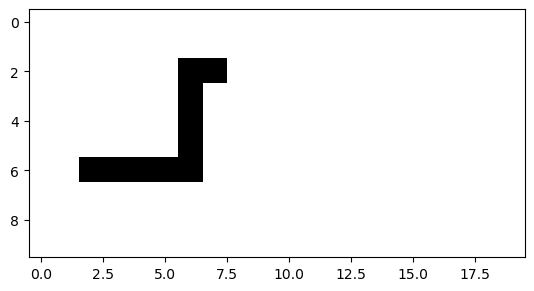

In [252]:
# Dimensions of the map.
height = 10
width = 20

# Bidimensional map as a list of lists.
# The empty cells are marked with 0, while blocks of walls with 1.
labyrinth = [[0 for c in range(width)] for r in range(height)]

for r in range(2, 7):
    labyrinth[r][6] = 1
    labyrinth[6][r] = 1
labyrinth[2][7] = 1

# Display labyrinth
%matplotlib inline
import matplotlib.pyplot as pyplot
pyplot.imshow(labyrinth, cmap='Greys', interpolation='nearest');

## Advanced functions

To simplify the iteration process, we can use: 

* `lambda`, the anonymous function which always returns an expression and has the following syntax:

```python
    lambda arguments: expression
```

In [253]:
# For this problem, we want to find the path 
# from the start point

start = (5, 5)

# to the end point.
final = (8, 8)

# Let us verify if having a list of tuples,
# their position corresponds to the endpoint.

# First, the lambda function:
is_final = lambda position: position == final

Lambda plays the role of an input argument in other functions, such as:

* `map`, which passes each element of the given iterable to a function:

```python
    map(function, iterable)
```

In [254]:
# Second, the map function:
list(map(is_final, [(1,1), (3, 6), (8, 8)]))

[False, False, True]

* `filter` can easily select the values from a sequence with a certain property:

```python
    filter(function, sequence)
```

In [255]:
list(filter(is_final, [(1,1), (3, 6), (8, 8)]))

[(8, 8)]

## The A* algorithm

With the help of the following tasks, create the building blocks of the algorithm.

### Task 0

**a.** Given a certain position represented by a `tuple`, find if its location is valid.

While exploring the bidirectional map, be careful to:

* check if the available coordinates are inside the plane (0-height, 0-width),
* verify if the position is free and not occupied by an obstacle.

In [256]:
def verify_location(position):
    # extract coordinates
    x, y = position
    # out of bounds check
    if x >= height or y >= width or x < 0 or y < 0:
        return False
    # check if the position is free
    return labyrinth[x][y] == 0


In [257]:
list(map(verify_location, [(-1,2), (height,3), (width,4), (5,5), (6,6), (0,9)])) 
# expected answer: [False, False, False, True, False, True]

[False, False, False, True, False, True]

**b.** Once you have verified the position, return its empty neighbours in a `list`.

Use both `filter` function and `verifiy_location` written above.

In [258]:
def get_neighbours(position):
    x, y = position
    result = list(filter(verify_location, [(x + 1, y + 1), (x + 1, y), (x + 1, y - 1), (x, y + 1), (x, y - 1), (x - 1, y + 1), (x - 1, y), (x - 1, y - 1)]))

    return result

In [259]:
[get_neighbours(p) for p in [(0,9), (5,5)]]
# expected answer: [[(1, 10), (0, 10), (1, 9), (0, 8), (1, 8)], [(4, 4), (4, 5), (5, 4)]]

[[(1, 10), (1, 9), (1, 8), (0, 10), (0, 8)], [(5, 4), (4, 5), (4, 4)]]

### Heuristic search

After checking the surroundings, we want to expand our frontier towards the goal, rather than searching for all possible directions.

### Task 1

**a.** Compute the _Euclidean distance_:

For two dimensions: 

\begin{equation*}
d(x, y) = \sqrt{(x_{1} - y_{1})^{2} + (x_{2} - y_{2})^{2}}
\end{equation*}

In [260]:
from math import sqrt

In [261]:
def euclidean_distance(a, b):
    x1, y1 = a
    x2, y2 = b
    distance = sqrt( pow((x1 - x2), 2) + pow((y1 - y2),2) )
    return distance

In [262]:
euclidean_distance((2,3), (4, 7))
# expected answer: 4.47213595499958

4.47213595499958

**b.** Compute the _Manhattan distance_:

For two dimensions: 

\begin{equation*}
d(x, y) = \left | x_{1} - x_{2} \right | +  \left | y_{1} - y_{2} \right |
\end{equation*}

In [263]:
def manhattan_distance(a, b):
    x1, x2 = a
    y1, y2 = b

    distance = abs(x1 - y1) + abs(x2 - y2)
    return distance

In [264]:
manhattan_distance((2,3), (4,0))
# expected answer: 5

5

To decide which location should be first checked from the _frontier_, we need to verify if the new possible route is better than the best previous one.

In practice, this could be accomplished using a **Priority Queue**. 

In [265]:
from heapq import heappop, heappush

priority_queue = []
heappush(priority_queue, ((1, 2), 'cost_so_far: 2'))
heappush(priority_queue, ((0, 1), 'cost_so_far: 1'))
heappush(priority_queue, ((1, 4), 'cost_so_far: 3'))

print(heappop(priority_queue))
print(heappop(priority_queue))
print(heappop(priority_queue))

((0, 1), 'cost_so_far: 1')
((1, 2), 'cost_so_far: 2')
((1, 4), 'cost_so_far: 3')


The frontier uses a priority queue for expansion and has the following structure: 

`frontier[(discovered_nodes_as_tuple), (estimated_cost, node)]`

Save the discovered nodes in a dictionary:

`d[new_node] = (parent, cost_so_far)`

* The movement between cells costs one unit and represents the `real cost g` which helps in measuring the actual distance.
* The estimated distance to the goal is given by the `heuristic function` defined before.

### Task 2

**a.** Implement **A\*** algorithm which receives as arguments the start node, the final node and the heuristic function.

In [266]:
from heapq import heappop, heappush

In [267]:
from heapq import heappop, heappush

def astar(start, end, h):
    frontier = []
    heappush(frontier, (0 + h(start, end), start))  # (f = g + h, node)
    # Discovered nodes as dictionary
    discovered = {start: (None, 0)}  # node -> (parent, g)
    
    while frontier:
        # Pop node with lowest f value
        current_f, current_node = heappop(frontier)
        
        if current_node == end:
            path = []
            while current_node:
                path.append(current_node)
                current_node = discovered[current_node][0]  
            return path[::-1], discovered 
      
        current_g = discovered[current_node][1]
        
        for neighbor in get_neighbours(current_node):
            new_g = current_g + 1  
            if neighbor not in discovered or new_g < discovered[neighbor][1]:
                discovered[neighbor] = (current_node, new_g)
                heappush(frontier, (new_g + h(neighbor, end), neighbor))
    
    
    # If the loop finishes without finding a path, return an empty list and discovered
    return [], discovered

**b.** Run the algorithm using different heuristics.

In [268]:
def display_map(discovered):
    cost_map = [[discovered[(r, c)][1] if (r, c) in discovered else 0 for c in range(width)] for r in range(height)]
    pyplot.imshow(cost_map, cmap='Greys', interpolation='nearest')
    pyplot.show()

Path using Euclidean distance: [(5, 5), (5, 4), (5, 3), (5, 2), (6, 1), (7, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8)]


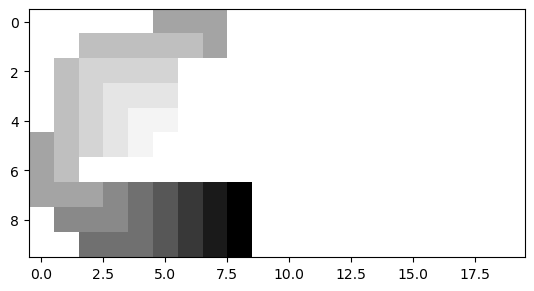

In [269]:
path, discovered = astar(start, final, euclidean_distance)
print("Path using Euclidean distance:", path)
display_map(discovered)

Path using Manhattan distance: [(5, 5), (4, 5), (3, 5), (2, 5), (1, 6), (1, 7), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8)]


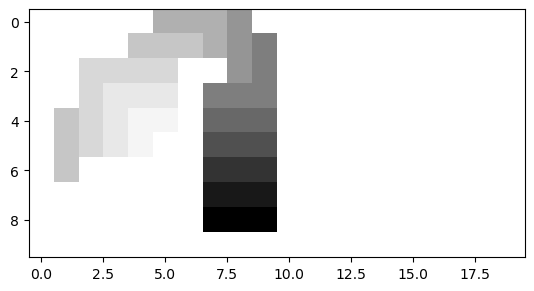

In [270]:
path, discovered = astar(start, final, manhattan_distance)
print("Path using Manhattan distance:", path)
display_map(discovered)

### Task 3

* Which heuristic function can be used in our problem, when we can move diagonally on the map?
* Which is the best one to use?
* What if we could only move in the 4 cardinal directions?

In [271]:
- In our problem, we can use both the Eucledian Distance and the Manhattan distance if we are not restricted to only orthogonal movements
- If we have diagonal movements, the Eucledian distance is a better heuristic function
- If we move only orthogonally, we Manhattan is a better heuristic function

SyntaxError: invalid syntax (573027113.py, line 1)